# Tune snow elevation percentile used to delineate snow line elevations using manually delineated snow lines

Rainey Aberle

September 2022

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import ee
import wxee as wx
import glob
import geopandas as gpd
import sys
from scipy import stats

In [2]:
# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# names of study sites
site_names = ['Gulkana', 'SCascade']
# path for output figures
figures_out_path = base_path+'figures/'

# add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

In [3]:
# Authenticate Google Earth Engine (GEE)
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

Downloading:   0%|          | 0.00/19.0k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/3.44k [00:00<?, ?iB/s]

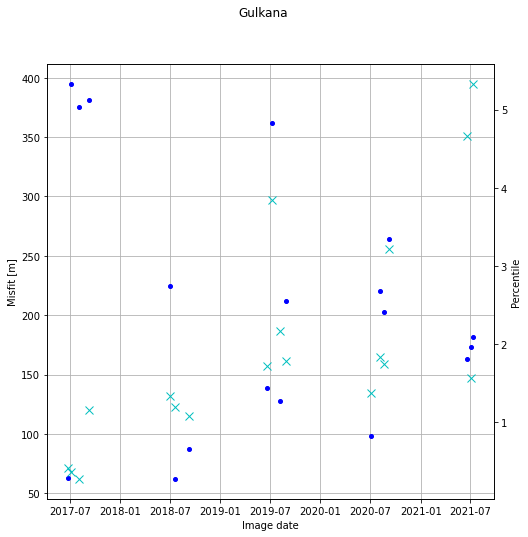

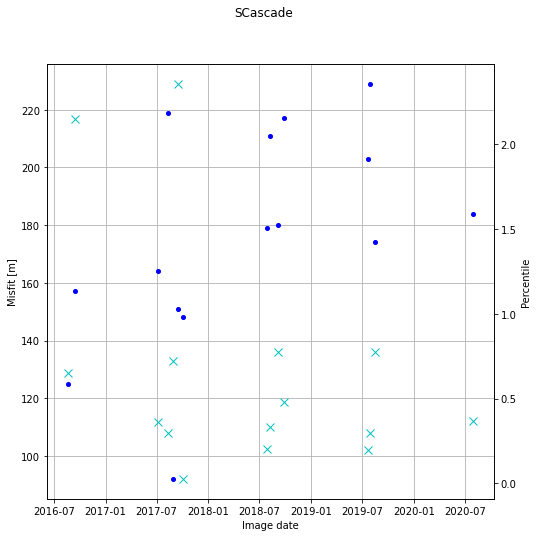

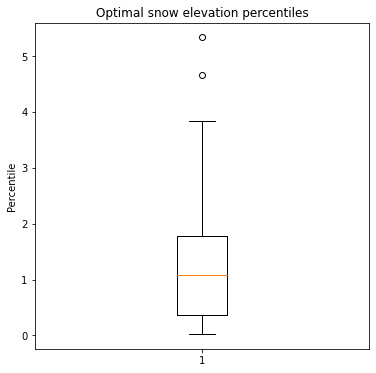

Median optimal snow elevation percentile =  1.0781829262825984


In [4]:
# -----Loop through sites
percentiles = [] # initialize optimal percentiles for estimating snow line elevation
for site_name in site_names:
    
    # define path to classified snow images
    im_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/classified/'
    
    # define path to digitized snow lines
    sl_path = base_path + '../snowline-package/' + site_name + '/snowlines/'
    
    # load AOI as gpd.GeoDataFrame
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)

    # load snow line shapefile names
    sl_fns = glob.glob(sl_path+'*.shp')
    sl_fns.sort() # sort chronologically
    
    # Set up figure for median observed and estimated snow line elevations for site
    fig1, ax1 = plt.subplots(figsize=(8,8))
    ax1.set_ylabel('Misfit [m]')
    ax1.set_xlabel('Image date')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Percentile')
    fig1.suptitle(site_name)
    ax1.grid()
    
    # initialize variables
    sl_elevs = [None]*len(sl_fns) # observed snow elevations
    datetimes = [None]*len(sl_fns) # image datetimes
    sl_elev_medians = [None]*len(sl_fns) # median observed snow line elevations
    snow_elev_percentiles = [None]*len(sl_fns) # estimated snow line elevation (i.e., optimal percentile of snow elevations)
    # loop through observed snow lines
    for sl_fn in sl_fns:
        
        # load snow line
        sl = gpd.read_file(sl_fn)
        # extract date from filename
        date = sl_fn.split('/'+site_name+'_')[1][0:8]
        # convert to datetime
        datetime = np.datetime64(date[0:4] + '-' + date[4:6] + '-' + date[6:8])
        datetimes = datetimes + [datetime]
        # reproject snow line to UTM
        sl_UTM = sl.to_crs(str(AOI_UTM.crs.to_epsg()))
        # interpolate elevation at snow line
        sl_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                            for x, y in list(zip(sl_UTM.geometry[0].xy[0], 
                                                 sl_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_elev_median = np.nanmedian(sl_elev)
        sl_elev_medians = sl_elev_medians + [sl_elev_median] # concatenate to list
        
        # open classified image from the same date
        im_fn = glob.glob(im_path + '*' + date + '*.tif')[0] # define file name
        im = rxr.open_rasterio(im_fn) # open image as xarray.DataArray
        im = im.where(im!=-9999) # remove no data values
        
        # determine snow-covered elevations
        band, x, y = im.indexes.values() # grab indices of image
        DEM_interp = DEM.interp(x=x, y=y, method="nearest") # interpolate DEM to image coordinates
        DEM_interp_masked = DEM_interp.where(im<=2) # mask image is not classified as snow
        snow_elev = DEM_interp_masked.elevation.data.flatten() # create array of snow elevations

        # determine the optimal percentile for estimating snow line elevation in classified image
        # using the median observed snow line elevation
        percentile = stats.percentileofscore(snow_elev, sl_elev_median, kind='rank')
        percentiles = percentiles + [percentile] # concatenate to list
        
        # extract snow line elevation in the classified image using the optimal percentile
        snow_elev_percentile = np.nanpercentile(snow_elev, percentile)
        snow_elev_percentiles = snow_elev_percentiles + [snow_elev_percentile]
        
        # estimate misfit between observed and estimated snow line elevation
        misfit = sl_elev_median - snow_elev_percentile

        # plot results
        ax2.plot(datetime, percentile, 'xc', markersize=8) # optimal percentile
        ax1.plot(datetime, misfit,'.b', markersize=8)
             
# Plot distribution of optimal percentiles
fig2, ax3 = plt.subplots(figsize=(6,6))
ax3.boxplot(percentiles)
ax3.set_ylabel('Percentile')
ax3.set_title('Optimal snow elevation percentiles')
plt.show()
print('Median optimal snow elevation percentile = ', np.median(percentiles))